
# Group GEMM
This group gemm kernel launches a fixed number of CTA to compute a group
of gemms. The scheduling is static and we do it on device.


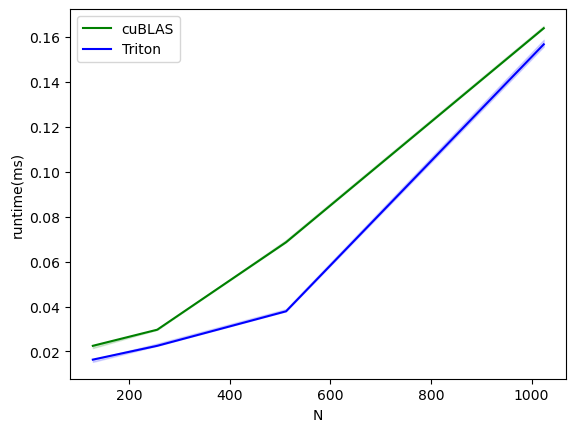

group-gemm-performance:
        N    cuBLAS    Triton
0   128.0  0.022528  0.016384
1   256.0  0.029696  0.022528
2   512.0  0.068608  0.037888
3  1024.0  0.163840  0.156672


In [5]:
# Copyright (c) 2023 NVIDIA Corporation & Affiliates. All rights reserved.
#
# Permission is hereby granted, free of charge, to any person obtaining
# a copy of this software and associated documentation files
# (the "Software"), to deal in the Software without restriction,
# including without limitation the rights to use, copy, modify, merge,
# publish, distribute, sublicense, and/or sell copies of the Software,
# and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
#
# The above copyright notice and this permission notice shall be
# included in all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
# EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
# MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT.
# IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY
# CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT,
# TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE
# SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

import torch

import triton
import triton.language as tl


@triton.autotune(
    configs=[
        triton.Config({
            'BLOCK_SIZE_M': 128,
            'BLOCK_SIZE_N': 128,
            'BLOCK_SIZE_K': 32,
            'NUM_SM': 84,
        }),
        triton.Config({
            'BLOCK_SIZE_M': 128,
            'BLOCK_SIZE_N': 128,
            'BLOCK_SIZE_K': 32,
            'NUM_SM': 128,
        }),
        triton.Config({
            'BLOCK_SIZE_M': 64,
            'BLOCK_SIZE_N': 64,
            'BLOCK_SIZE_K': 32,
            'NUM_SM': 84,
        }),
        triton.Config({
            'BLOCK_SIZE_M': 64,
            'BLOCK_SIZE_N': 64,
            'BLOCK_SIZE_K': 32,
            'NUM_SM': 128,
        }),
    ],
    key=['group_size'],
)
@triton.jit
def grouped_matmul_kernel(
    # device tensor of matrices pointers
    group_a_ptrs,
    group_b_ptrs,
    group_c_ptrs,
    # device tensor of gemm sizes. its shape is [group_size, 3]
    # dim 0 is group_size, dim 1 is the values of <M, N, K> of each gemm
    group_gemm_sizes,
    # device tensor of leading dimension sizes. its shape is [group_size, 3]
    # dim 0 is group_size, dim 1 is the values of <lda, ldb, ldc> of each gemm
    g_lds,
    # number of gemms
    group_size,
    # number of virtual SM
    NUM_SM: tl.constexpr,
    # tile sizes
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_K: tl.constexpr,
):
    tile_idx = tl.program_id(0)
    last_problem_end = 0
    for g in range(group_size):
        # get the gemm size of the current problem
        gm = tl.load(group_gemm_sizes + g * 3)
        gn = tl.load(group_gemm_sizes + g * 3 + 1)
        gk = tl.load(group_gemm_sizes + g * 3 + 2)
        num_m_tiles = tl.cdiv(gm, BLOCK_SIZE_M)
        num_n_tiles = tl.cdiv(gn, BLOCK_SIZE_N)
        num_tiles = num_m_tiles * num_n_tiles
        # iterate through the tiles in the current gemm problem
        while (tile_idx >= last_problem_end and tile_idx < last_problem_end + num_tiles):
            # pick up a tile from the current gemm problem
            k = gk
            lda = tl.load(g_lds + g * 3)
            ldb = tl.load(g_lds + g * 3 + 1)
            ldc = tl.load(g_lds + g * 3 + 2)
            a_ptr = tl.load(group_a_ptrs + g).to(tl.pointer_type(tl.float16))
            b_ptr = tl.load(group_b_ptrs + g).to(tl.pointer_type(tl.float16))
            c_ptr = tl.load(group_c_ptrs + g).to(tl.pointer_type(tl.float16))
            # figure out tile coordinates
            tile_idx_in_gemm = tile_idx - last_problem_end
            tile_m_idx = tile_idx_in_gemm // num_n_tiles
            tile_n_idx = tile_idx_in_gemm % num_n_tiles

            # do regular gemm here
            offs_am = tile_m_idx * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
            offs_bn = tile_n_idx * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
            offs_k = tl.arange(0, BLOCK_SIZE_K)
            a_ptrs = a_ptr + offs_am[:, None] * lda + offs_k[None, :]
            b_ptrs = b_ptr + offs_k[:, None] * ldb + offs_bn[None, :]
            accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
            for kk in range(0, tl.cdiv(k, BLOCK_SIZE_K)):
                # hint to Triton compiler to do proper loop pipelining
                tl.multiple_of(a_ptrs, [16, 16])
                tl.multiple_of(b_ptrs, [16, 16])
                # assume full tile for now
                a = tl.load(a_ptrs)
                b = tl.load(b_ptrs)
                accumulator += tl.dot(a, b)
                a_ptrs += BLOCK_SIZE_K
                b_ptrs += BLOCK_SIZE_K * ldb
            c = accumulator.to(tl.float16)

            offs_cm = tile_m_idx * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
            offs_cn = tile_n_idx * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
            c_ptrs = c_ptr + ldc * offs_cm[:, None] + offs_cn[None, :]

            # assumes full tile for now
            tl.store(c_ptrs, c)

            # go to the next tile by advancing NUM_SM
            tile_idx += NUM_SM

        # get ready to go to the next gemm problem
        last_problem_end = last_problem_end + num_tiles


def group_gemm_fn(group_A, group_B):
    device = torch.device('cuda')
    assert len(group_A) == len(group_B)
    group_size = len(group_A)

    A_addrs = []
    B_addrs = []
    C_addrs = []
    g_sizes = []
    g_lds = []
    group_C = []
    for i in range(group_size):
        A = group_A[i]
        B = group_B[i]
        assert A.shape[1] == B.shape[0]
        M, K = A.shape
        K, N = B.shape
        C = torch.empty((M, N), device=device, dtype=A.dtype)
        group_C.append(C)
        A_addrs.append(A.data_ptr())
        B_addrs.append(B.data_ptr())
        C_addrs.append(C.data_ptr())
        g_sizes += [M, N, K]
        g_lds += [A.stride(0), B.stride(0), C.stride(0)]

    # note these are device tensors
    d_a_ptrs = torch.tensor(A_addrs, device=device)
    d_b_ptrs = torch.tensor(B_addrs, device=device)
    d_c_ptrs = torch.tensor(C_addrs, device=device)
    d_g_sizes = torch.tensor(g_sizes, dtype=torch.int32, device=device)
    d_g_lds = torch.tensor(g_lds, dtype=torch.int32, device=device)
    # we use a fixed number of CTA, and it's auto-tunable
    grid = lambda META: (META['NUM_SM'], )
    grouped_matmul_kernel[grid](
        d_a_ptrs,
        d_b_ptrs,
        d_c_ptrs,
        d_g_sizes,
        d_g_lds,
        group_size,
    )

    return group_C


group_m = [1024, 512, 256, 128]
group_n = [1024, 512, 256, 128]
group_k = [1024, 512, 256, 128]
group_A = []
group_B = []
assert len(group_m) == len(group_n)
assert len(group_n) == len(group_k)
group_size = len(group_m)
for i in range(group_size):
    M = group_m[i]
    N = group_n[i]
    K = group_k[i]
    A = torch.rand((M, K), device="cuda", dtype=torch.float16)
    B = torch.rand((K, N), device="cuda", dtype=torch.float16)
    group_A.append(A)
    group_B.append(B)

tri_out = group_gemm_fn(group_A, group_B)
ref_out = [torch.matmul(a, b) for a, b in zip(group_A, group_B)]
for i in range(group_size):
    assert torch.allclose(ref_out[i], tri_out[i], atol=1e-2, rtol=1e-3)


# only launch the kernel, no tensor preparation here to remove all overhead
def triton_perf_fn(a_ptrs, b_ptrs, c_ptrs, sizes, lds, group_size):
    grid = lambda META: (META['NUM_SM'], )
    grouped_matmul_kernel[grid](
        a_ptrs,
        b_ptrs,
        c_ptrs,
        sizes,
        lds,
        group_size,
    )


def torch_perf_fn(group_A, group_B):
    for a, b in zip(group_A, group_B):
        torch.matmul(a, b)


@triton.testing.perf_report(
    triton.testing.Benchmark(
        # argument names to use as an x-axis for the plot
        x_names=['N'],
        x_vals=[2**i for i in range(11, 15)],  # different possible values for `x_name`
        line_arg='provider',
        # argument name whose value corresponds to a different line in the plot
        # possible values for `line_arg``
        line_vals=['cublas', 'triton'],
        # label name for the lines
        line_names=["cuBLAS", "Triton"],
        # line styles
        styles=[('green', '-'), ('blue', '-')],
        ylabel="runtime(ms)",  # label name for the y-axis
        plot_name="group-gemm-performance",
        # name for the plot. Used also as a file name for saving the plot.
        args={},
    ))
def benchmark(N, provider):
    group_size = 4
    group_A = []
    group_B = []
    A_addrs = []
    B_addrs = []
    C_addrs = []
    g_sizes = []
    g_lds = []
    group_C = []
    for i in range(group_size):
        A = torch.rand((N, N), device="cuda", dtype=torch.float16)
        B = torch.rand((N, N), device="cuda", dtype=torch.float16)
        C = torch.empty((N, N), device="cuda", dtype=torch.float16)
        group_A.append(A)
        group_B.append(B)
        group_C.append(C)
        A_addrs.append(A.data_ptr())
        B_addrs.append(B.data_ptr())
        C_addrs.append(C.data_ptr())
        g_sizes += [N, N, N]
        g_lds += [N, N, N]

    d_a_ptrs = torch.tensor(A_addrs, device="cuda")
    d_b_ptrs = torch.tensor(B_addrs, device="cuda")
    d_c_ptrs = torch.tensor(C_addrs, device="cuda")
    d_g_sizes = torch.tensor(g_sizes, dtype=torch.int32, device="cuda")
    d_g_lds = torch.tensor(g_lds, dtype=torch.int32, device="cuda")

    quantiles = [0.5, 0.2, 0.8]
    if provider == 'cublas':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch_perf_fn(group_A, group_B), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: triton_perf_fn(d_a_ptrs, d_b_ptrs, d_c_ptrs, d_g_sizes, d_g_lds, group_size), quantiles=quantiles)
    return ms, max_ms, min_ms


benchmark.run(show_plots=True, print_data=True)